

```


1.   StateGraph: The core of our application, defining the flow of our Travel Planner.
2.   PlannerState: A custom type representing the state of our planning process.
3.   Node Functions: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4.   LLM Integration: Utilizing a language model to generate the final itinerary.



```



In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.32
    Uninstalling langchain-core-0.3.32:
      Successfully uninstalled langchain-core-0.3.32


In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate, ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Define Agent

In [3]:
class PlannerState(TypedDict):
  messages : Annotated[ List[ HumanMessage | AIMessage ], 'the messages in the conversation' ]
  city : str
  interests: List[ str ]
  iterinary: str

In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = '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',
    model_name = 'llama-3.3-70b-versatile'
)
# result = llm.invoke('What is Multi AI Agent')
# result.content

In [5]:
iterinary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Define Agent Function

In [6]:
def input_city( state: PlannerState ) -> PlannerState:
  print( 'Please enter the city you want to visit for your day trip:' )
  user_message = input('Your input')

  return {
      **state,
      'city': user_message,
      'messages': state['messages'] + [ HumanMessage( content = user_message ) ]
  }

def input_interest( state: PlannerState ) -> PlannerState:
  print( f'''Please enter your interest for the trip to: { state [ 'city' ] } (comma-separated): ''' )
  user_message = input('Your input')

  return {
      **state,
      'interests': [interest.strip() for interest in user_message.split(',')],
      'messages': state['messages'] + [ HumanMessage( content = user_message ) ]
  }


def create_iterinary( state: PlannerState ) -> PlannerState:
  print( f'''Creating an iterinary for {state['city']} based on interests: {', '.join(state['interests'])}''' )

  response = llm.invoke(iterinary_prompt.format_messages(city = state['city'], interests = ', '.join( state['interests'] ) ))

  print('\nFinal Iterinary: ')
  print(response.content)
  return {
      **state,
      'messages': state['messages'] + [ AIMessage( content = response.content ) ],
      'iterinary': response.content
  }



Create and Compile the Graph

In [7]:
workflow = StateGraph( PlannerState )

workflow.add_node( 'input_city', input_city )
workflow.add_node( 'input_interest', input_interest )
workflow.add_node( 'create_iterinary', create_iterinary )

workflow.set_entry_point( 'input_city' )

workflow.add_edge('input_city', 'input_interest' )
workflow.add_edge('input_interest', 'create_iterinary' )
workflow.add_edge('create_iterinary', END )

app = workflow.compile()

Display the graph structure

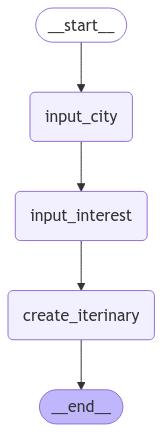

In [8]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

Define a function that runs the graph

In [9]:
def travel_planner( user_request: str ):
  print(f'''Initial Request: { user_request }\n''')
  state = {
      'messages': [ HumanMessage( content = user_request ) ],
      'city': '',
      'interests': [],
      'iterinary': '',
  }

  for output in app.stream( state ):
    pass

In [10]:
user_request = 'I want to plan a day trip'
travel_planner( user_request )

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip:
Your inputCharlotte
Please enter your interest for the trip to: Charlotte (comma-separated): 
Your inputUptown, Dairy Queen, Jenny
Creating an iterinary for Charlotte based on interests: Uptown, Dairy Queen, Jenny

Final Iterinary: 
Based on your interests in Uptown, Dairy Queen, and Jenny (assuming Jenny is a person you'd like to spend time with), here's a brief, bulleted itinerary for your day trip to Charlotte:

* 10:00 AM: Start the day with breakfast in Uptown Charlotte, exploring the city's vibrant atmosphere and historic landmarks.
* 12:00 PM: Meet Jenny at a local restaurant in Uptown for lunch and catch up.
* 2:00 PM: Take a stroll through the NASCAR Hall of Fame or visit the Mint Museum, both located in Uptown.
* 4:00 PM: Treat yourselves to a cool dessert at Dairy Queen, a perfect way to beat the heat.
* 6:00 PM: End the day with dinner and drinks in the NoDa neighborhood, 

In [11]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [13]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    city: str
    interests: List[str]
    itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)],
    }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
    return {
        **state,
        "interests": [interest.strip() for interest in interests.split(',')],
        "messages": state['messages'] + [HumanMessage(content=interests)],
    }

def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests'])))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Define the Gradio application
def travel_planner(city: str, interests: str):
    # Initialize state
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "itinerary": "",
    }

    # Process the city and interests inputs
    state = input_city(city, state)
    state = input_interests(interests, state)

    # Generate the itinerary
    itinerary = create_itinerary(state)

    return itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

# Launch the Gradio application
interface.launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


themes/theme_schema@0.0.1.json:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a83fae8ccc3dac60b0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
